# Finetuning HiFi-GAN

Improving speech quality by finetuning HiFi-GAN on synthesized mel-spectrograms from FastPitch.

## Generating synthetic mels

To generate mel-spectrograms from FastPitch, we can use `generate_spectrogram` method defined in `nemo/collections/tts/models/fastpitch.py`. However, the resulting spectrogram may be different from ground truth mel spectrogram, as shown below:

In [7]:
test_audio_filepath = "/home/irene/datasets/datasetCastellanoReducido/19demarzo/19demarzo_0022.wav"
test_audio_text = "Aquel fue uno de los cuadros más terribles que he presenciado en mi vida."

In [6]:
from matplotlib.pyplot import imshow
from nemo.collections.tts.models import FastPitchModel
from matplotlib import pyplot as plt
import librosa
import librosa.display
import torch
import soundfile as sf
import numpy as np
from nemo.collections.tts.parts.utils.tts_dataset_utils import BetaBinomialInterpolator

def load_wav(audio_file):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
    return samples.transpose()

def plot_logspec(spec, axis=None):
    librosa.display.specshow(
        librosa.amplitude_to_db(spec, ref=np.max),
        y_axis='linear',
        x_axis="time",
        fmin=0,
        fmax=8000,
        ax=axis
    )

[NeMo W 2023-06-30 22:51:56 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.


Extension horovod.torch has not been built: /usr/local/lib/python3.10/dist-packages/horovod/torch/mpi_lib_v2.cpython-310-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.


2023-06-30 22:51:57.695421: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# load fastpitch and hifigan models
import glob, os

file_list = glob.glob("/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_08*/checkpoints/*")
fastpitch_model_path = sorted(file_list, key=os.path.basename)[0] # path_to_fastpitch_nemo_or_ckpt
print("# CARGAREMOS EL MODELO ....... : ", os.path.basename(fastpitch_model_path))
print("# DE LA CARPETA .............. : ", os.path.dirname(fastpitch_model_path))

if ".nemo" in fastpitch_model_path:
    spec_gen_model_1 = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_gen_model_1 = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

# CARGAREMOS EL MODELO ....... :  FastPitch--val_loss=0.7692-epoch=50-last.ckpt
# DE LA CARPETA .............. :  /home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_08-01-40/checkpoints


[NeMo W 2023-06-30 20:29:19 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: train_manifest_text_normed.json
      sample_rate: 22050
      sup_data_path: sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 15
      min_duration: 0.1
      ignore_file: null
      trim: true
      trim_top_db: 50
      trim_frame_length: 1024
      trim_hop_length: 256
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004522404789
      pitch_norm: true
      pitch_mean: 126.73465728759766
      pitch_std: 38.099849700927734
    dataloader_params:
      drop_last: false
   

[NeMo I 2023-06-30 20:29:19 features:289] PADDING: 1


In [10]:
# spec_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()

So we have 2 types of mel spectrograms that we can use for finetuning HiFi-GAN:

### 1. Original mel spectrogram generated from original audio file

loading original melspec


spectrogram shape =  (80, 398)


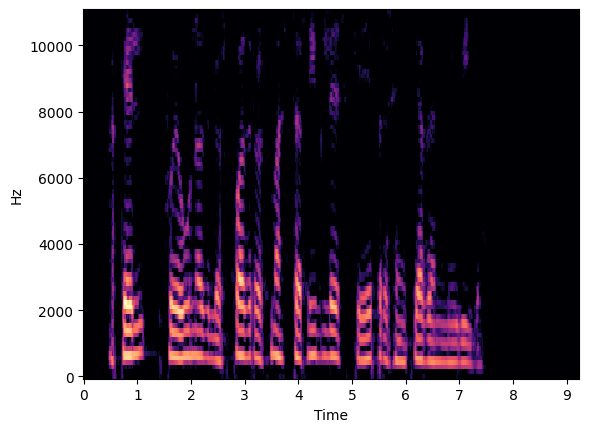

In [11]:
print("loading original melspec")
y, sr = librosa.load(test_audio_filepath)
# change n_fft, win_length, hop_length parameters below based on your specific config file
spectrogram2 = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, win_length=1024, hop_length=256)
spectrogram = spectrogram2[ :80, :]
print("spectrogram shape = ", spectrogram.shape)
plot_logspec(spectrogram)
plt.show()

### 2. Mel spectrogram predicted from FastPitch

loading fastpitch melspec via generate_spectrogram


spectrogram shape =  (80, 271)


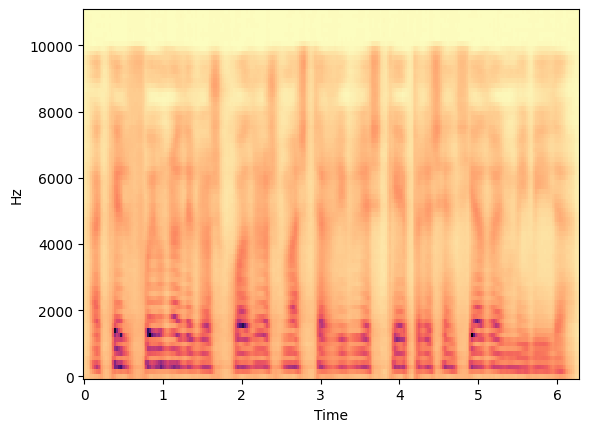

In [12]:
print("loading fastpitch melspec via generate_spectrogram")
with torch.no_grad():
    text = spec_gen_model_1.parse(test_audio_text, normalize=False)
    spectrogram = spec_gen_model_1.generate_spectrogram(
      tokens=text,
      speaker=None,
    )
spectrogram = spectrogram.to('cpu').numpy()[0]
plot_logspec(spectrogram)
print("spectrogram shape = ", spectrogram.shape)
plt.show()

**Note**: The above predicted spectrogram has the duration of 241 frames which is not equal to the ground truth 345 frames. In order to finetune HiFi-GAN we need mel spectrogram predicted from FastPitch with ground truth alignment and duration.

### 2.1 Mel spectrogram predicted from FastPitch with groundtruth alignment and duration

loading fastpitch melspec via forward method with groundtruth alignment and duration


spectrogram shape =  (80, 398)


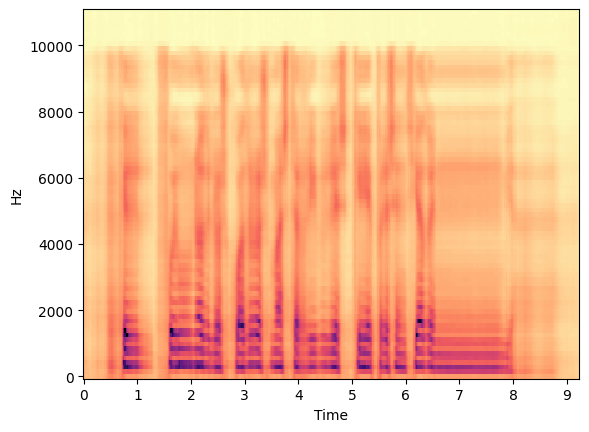

In [13]:
print("loading fastpitch melspec via forward method with groundtruth alignment and duration")
with torch.no_grad():
    device = spec_gen_model_1.device
    beta_binomial_interpolator = BetaBinomialInterpolator()
    text = spec_gen_model_1.parse(test_audio_text, normalize=False)
    text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)
    audio = load_wav(test_audio_filepath)
    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)
    spect, spect_len = spec_gen_model_1.preprocessor(input_signal=audio, length=audio_len)
    attn_prior = torch.from_numpy(
      beta_binomial_interpolator(spect_len.item(), text_len.item())
    ).unsqueeze(0).to(text.device)
    spectrogram = spec_gen_model_1.forward(
      text=text,
      input_lens=text_len,
      spec=spect,
      mel_lens=spect_len,
      attn_prior=attn_prior,
      speaker=None,
    )[0]
spectrogram = spectrogram.to('cpu').numpy()[0]
print("spectrogram shape = ", spectrogram.shape)
plot_logspec(spectrogram)
plt.show()

In our experience,
- Finetuning with #1 has artifacts from the original audio (noise) that get passed on as input to the vocoder resulting in artifacts in vocoder output in the form of noise.
- <b> On the other hand, #2.1 (i.e. `Mel spectrogram predicted from FastPitch with groundtruth alignment and duration`) gives the best results because it enables HiFi-GAN to learn mel spectrograms generated by FastPitch as well as duration distributions closer to the real world (i.e. ground truth) durations. </b>

From implementation perspective - we follow the same process described in [Finetuning FastPitch for a new speaker](FastPitch_Finetuning.ipynb) - i.e. take the latest checkpoint from FastPitch training and predict spectrograms for each of the input records in `train_manifest_text_normed.json`, `test_manifest_text_normed.json` and `val_manifest_text_normed.json`. NeMo provides an efficient script, [scripts/dataset_processing/tts/generate_mels.py](https://raw.githubusercontent.com/nvidia/NeMo/main/scripts/dataset_processing/tts/generate_mels.py), to generate Mel-spectrograms in the directory `NeMoGermanTTS/mels` and also create new JSON manifests with a suffix `_mel` by adding a new key `"mel_filepath"`. For example, `train_manifest_text_normed.json` corresponds to `train_manifest_text_normed_mel.json` saved in the same directory. You can run the following CLI to obtain the new JSON manifests.

In [4]:
# os.chdir("/home/irene/datasets")
# !cd / && python /home/irene/datasets/NemoSpanishTTS/generate_mels.py \
#     --cpu \
#     --fastpitch-model-ckpt {fastpitch_model_path.split("/", maxsplit=1)[1]} \
#     --input-json-manifests /home/irene/datasets/NemoSpanishTTS/train_manifest_text_normed.json /home/irene/datasets/NemoSpanishTTS/val_manifest_text_normed.json /home/irene/datasets/NemoSpanishTTS/test_manifest_text_normed.json \
#     --output-json-manifest-root ./

# # os.chdir("/home/irene/datasets")

# # !(cd NemoSpanishTTS && python generate_mels.py \
# #     --cpu \
# #     --fastpitch-model-ckpt {fastpitch_model_path.split("/", maxsplit=1)[1]} \
# #     --input-json-manifests train_manifest_text_normed.json val_manifest_text_normed.json test_manifest_text_normed.json \
# #     --output-json-manifest-root ./)


Revisiting how we implement #2.1 (i.e. Predicted mel spectrogram predicted from FastPitch with groundtruth alignment and duration):

1. Notice above that we use audio from dataset (`audio` variable) to compute spectrogram length (`spect_len`):
    ```python
    spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)
    ```
2. and groundtruth alignment (`attn_prior`).
    ```python
    attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
    ```
3. We use both of them to generate synthetic mel spectrogram via `spec_model.forward` method:
    ```python
    spectrogram = spec_model.forward(
          text=text,
          input_lens=text_len,
          spec=spect,
          mel_lens=spect_len,
          attn_prior=attn_prior,
          speaker=speaker,
        )[0]
    ```

Repeat the above script for train and validation datasets as well.

In [3]:
# Example HiFi-GAN manifest:
!head -n1 NemoSpanishTTS/train_manifest_text_normed_mel.json | jq


head: cannot open 'NemoSpanishTTS/train_manifest_text_normed_mel.json' for reading: No such file or directory


In [2]:
hfg_ngc = "tts_en_lj_hifigan_ft_mixerttsx" # NGC pretrained model name: https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/tts_en_lj_hifigan

A continuación, se ejecuta el script creado fptts-finetuningHifigan.sh

<b>Note</b>: We've limited the above run to 10 steps only, so we can validate the implementation within the scope of this tutorial. We recommend evaluating around every 50 steps HiFi-GAN until you get desired quality results.

In [1]:
# !cd /home/irene/datasets/NemoSpanishTTS && CUDA_VISIBLE_DEVICES=0 python hifigan_finetune.py --config-path . --config-name hifigan.yaml \
#     model.max_steps=10 \
#     model.optim.lr=0.00001 \
#     ~model.optim.sched \
#     train_dataset=train_manifest_text_normed_mel.json \
#     validation_datasets=val_manifest_text_normed_mel.json \
#     exp_manager.exp_dir=resultSpanishTTS \
#     +init_from_pretrained_model={hfg_ngc} \
#     +trainer.val_check_interval=5 \
#     trainer.check_val_every_n_epoch=null \
#     model/train_ds=train_ds_finetune \
#     model/validation_ds=val_ds_finetune \
#     exp_manager.create_wandb_logger=true \
#     exp_manager.wandb_logger_kwargs.name="tutorial_2" \
#     exp_manager.wandb_logger_kwargs.project="SpanishTTS"